In [1]:
# 导入需要的包
import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

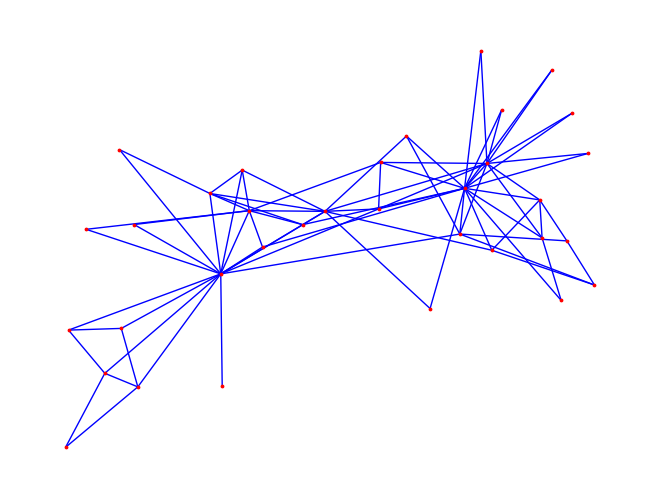

In [2]:
###
### 导入 networkx 包 以及一个作为例子的图
import networkx as nx

G=nx.karate_club_graph()

nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')  # Draw the graph generated above

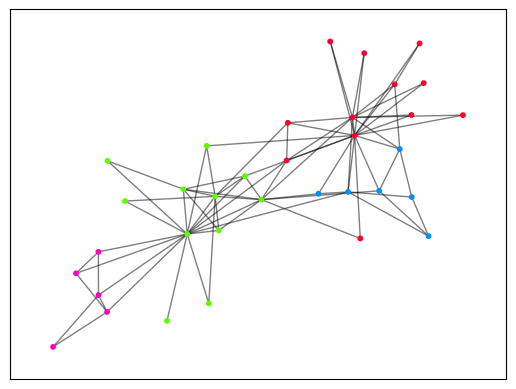

In [3]:
# 利用 Louvain 算法进行社群识别并画图
# louvain_membership 一开始是作为一个 dict 给出的，后来将其转化为一个 list
from community import community_louvain
# import matplotlib
# import matplotlib.pyplot as plt


louvain_membership = community_louvain.best_partition(G)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      #louvain_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(louvain_membership.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [4]:
print(f"Louvain algorithm gives {max(louvain_membership.values())+1} communities.")

Louvain algorithm gives 4 communities.


In [5]:
louvain_clustering = Clustering(elm2clu_dict={i: [louvain_membership[i]] for i in louvain_membership.keys()})

Processing 5-dim case...
Completed graph embedding


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/24 22:05:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/24 22:05:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


5-dimensional NMIs: 0.09847710813991069 0.2063167435702116
5-dimensional ECSim: 0.24261522790934553 0.30774658348187756


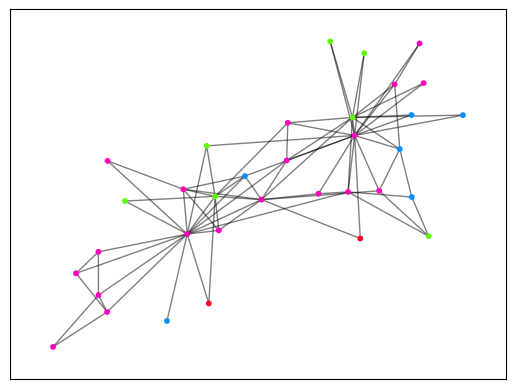

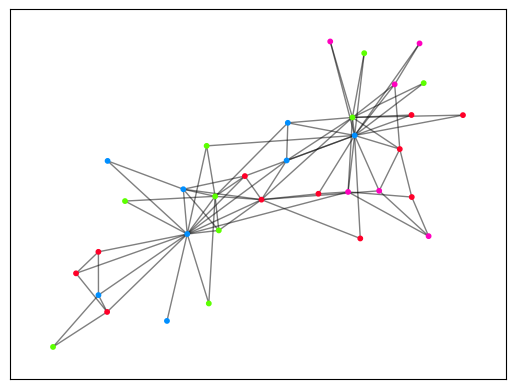

In [6]:
### Locally Linear 方法
from gem.embedding.lle import LocallyLinearEmbedding

for D in range(5, 6):
    if D!=9:
        print(f"Processing {D}-dim case...")
        lle_model = LocallyLinearEmbedding(d=D)

        lle_embd = lle_model.learn_embedding(graph=G, is_weighted=True, no_python=True)
        print("Completed graph embedding")
    
        lle_vec = [Vectors.dense(row) for row in lle_embd]
        lle_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in lle_vec], ["embd"])

        euclid_kmeans = KMeans(k=4, featuresCol="embd")
        cosine_kmeans = KMeans(k=4, featuresCol="embd", distanceMeasure="cosine")
        lle_euclid_model = euclid_kmeans.fit(lle_prep)
        lle_cosine_model = cosine_kmeans.fit(lle_prep)

        # Add the cluster assignment to the DataFrame
        lle_euclid = lle_euclid_model.transform(lle_prep)
        lle_cosine = lle_cosine_model.transform(lle_prep)

        # Extract the cluster assignment and convert it to a list
        lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
        lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

        # Calculate the NMI
        lle_euclid_nmi = normalized_mutual_info_score(list(lle_euclid_membership), list(louvain_membership.values()))
        lle_cosine_nmi = normalized_mutual_info_score(list(lle_cosine_membership), list(louvain_membership.values()))

        print(f"{D}-dimensional NMIs:", lle_euclid_nmi, lle_cosine_nmi)

        lle_euclid_clustering = Clustering(elm2clu_dict={i: [lle_euclid_membership[i]] for i in range(len(lle_euclid_membership))})
        lle_cosine_clustering = Clustering(elm2clu_dict={i: [lle_cosine_membership[i]] for i in range(len(lle_cosine_membership))})

        lle_euclid_similarity = sim.element_sim(louvain_clustering, lle_euclid_clustering, alpha=0.9)
        lle_cosine_similarity = sim.element_sim(louvain_clustering, lle_cosine_clustering, alpha=0.9)

        print(f"{D}-dimensional ECSim:", lle_euclid_similarity, lle_cosine_similarity)
        nx.draw_networkx_nodes(G,
                      pos,
                      #louvain_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(lle_euclid_membership)
                      )
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        plt.show()
        nx.draw_networkx_nodes(G,
                pos,
                #louvain_membership.keys(),
                node_size=10,
                cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                node_color=list(lle_cosine_membership)
                )
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        plt.show()